** This code loads models saved and trained by kernels LSTM_model_v2, GRU_model on training set, and creates an ensemble network by combining these nets **

**Change Log :**
<br><br>Ver1:
* Creating ensemble model with GRU, LSTM, RNN as first layer and FNN as 2nd layer. 
* Inputs to ensemble are validation set. 
* Predictions from pre-trained models are used as input to the FNN.
* Right now validation and test are split at 2nd eearthquake which doesn't give much data for training.
* We need to split data around the mid point, and train all layer 0 models on the training set, and layer 1 on the validation set
<br><br>Ver 2, 3 :
* Corrected input data format generated by generator
<br><br>Ver 4:
* Dividing data along 8th earthquake
<br><br>Ver 5 :
* Dividing along 6th earthquake
<br><br>Ver 6 :
* Added predictions & ground truth plot
<br><br>Ver 7:
* Added FFT model to stack, modified create_x, generators, predict, groundtruth plot, and submission
* Added new feature extraction method, to go along with the LSTM and GRU
* Used train_gen 4-16eq, valid_gen 1-3eq
<br><br>Ver 8:
* Modified train_gen size to 6-16eq, and valid_gen to 1-5eq
<br><br>Ver 10:
* Modified generator data sizes (2nd eq)
<br><br>Ver 11:
* Added more regularization
* Added DeepRNN model
<br><br> 5.1 v1:
* Added CRNN model
* Tried adding maxpool regularization to stack model but failed
<br><br> Ver 12:
* 5.1v1 along with 40% dropout, removed some dense layers
<br><br> Ver 13
* Change sigmoid to relu

Need to fix:
1. dimension error for finding loss of FFT model (to keep it clean, will need to input a number for create_x so that it will run differently for each model)
2. stacked model layers don't allow repeated names (fixed, modify the stack_generator)
3. We can still play around with which portion of the samples the train_gen, stack_gen, stackvalid_gen will get


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['LANL-Earthquake-Prediction', 'modelsforstacking']


In [2]:
print(os.listdir("../input/modelsforstacking"))

['1.3GRU_v11.hdf5', '1.5CRNN_v1.hdf5', '1.2Parul(FFT)RNN starter for huge time series_v1.hdf5', '1.3LSTM_v10.hdf5', '1.1SimpleRNN_modelv7.hdf5', '1.1LSTM_modelv8.hdf5', '1.2GRU_Fork_RNN starter for huge time seriesv5.hdf5', '1.1GRU_modelv8.hdf5', '1.4DeepRNN_v13.hdf5']


In [3]:
DATA_PATH = '../input/LANL-Earthquake-Prediction/'
LSTM_MODEL_PATH = "../input/modelsforstacking/1.3LSTM_v10.hdf5"
#GRU_MODEL_PATH = "../input/modelsforstacking/1.1GRU_modelv8.hdf5"
GRU_MODEL_PATH = "../input/modelsforstacking/1.3GRU_v11.hdf5"
FFT_MODEL_PATH = "../input/modelsforstacking/1.2Parul(FFT)RNN starter for huge time series_v1.hdf5"
DeepRNN_MODEL_PATH = "../input/modelsforstacking/1.4DeepRNN_v13.hdf5"
ConvRNN_MODEL_PATH = "../input/modelsforstacking/1.5CRNN_v1.hdf5"

## BASIC IDEA OF THE KERNEL
The idea is to use Stacked Generalization Ensemble Model, using the models that we trained earlier, i.e. LSTM_model and GRU_model, and any more that we add.
The data consists of a one dimensional time series x with 600 Mio data points. 
At test time, we will see a time series of length 150'000 to predict the next earthquake.
The idea of this kernel is to randomly sample chunks of length 150'000 from x, derive some
features and use them to update weights of a recurrent neural net with 150'000 / 1000 = 150
time steps. 


In [4]:

import numpy as np 
import pandas as pd
import os
from tqdm import tqdm

# Fix seeds
from numpy.random import seed
seed(639)
from tensorflow import set_random_seed
set_random_seed(5944)

# Import
%time float_data = pd.read_csv(DATA_PATH + "train.csv", dtype={"acoustic_data": np.float32, "time_to_failure": np.float32}).values

CPU times: user 2min 4s, sys: 11.9 s, total: 2min 16s
Wall time: 2min 16s


In [5]:
np.shape(float_data)

(629145480, 2)

### Earthquake Positions

In [6]:
earthquakes = [5656573, 50085877, 104677355, 138772452, 187641819, 218652629, 245829584, 307838916, 338276286, 375377847, 419368879, 461811622, 495800224, 528777114, 585568143, 621985672]


Helper function for the data generator. Extracts mean, standard deviation, and quantiles per time step.
Can easily be extended. Expects a two dimensional array.

In [7]:
def extract_features(z):
     return np.c_[z.mean(axis=1), 
                  z.min(axis=1),
                  z.max(axis=1),
                  z.std(axis=1)]
def extract_features2(z):
     return np.c_[z.mean(axis=1), 
                  z.min(axis=1),
                  z.max(axis=1),
                  z.std(axis=1),
                  z.sum(axis=1),
                  np.abs(z).max(axis=1),
                  np.abs(z).min(axis=1),
                  np.quantile(z, 0.01, axis=1),
                  np.quantile(z, 0.05, axis=1),
                  np.quantile(z, 0.95, axis=1),
                  np.quantile(z, 0.99, axis=1),
                  np.mean((np.diff(z, axis=1)),axis=1)]
def extract_featuresFFT(z):
    #FFT transform values
    zc = np.fft.fft(z)
    realFFT = np.real(zc)
    imagFFT = np.imag(zc)
    return np.c_[z.mean(axis=1), 
                  z.min(axis=1),
                  z.max(axis=1),
                  z.std(axis=1),
                  z.sum(axis = 1),
                 realFFT.mean(axis=1),
                 realFFT.min(axis=1),
                 realFFT.max(axis=1),
                 realFFT.std(axis=1),
                 imagFFT.mean(axis=1),
                 imagFFT.min(axis=1),
                 imagFFT.max(axis=1),
                 imagFFT.std(axis=1)]


For a given ending position "last_index", we split the last 150'000 values 
of "x" into 150 pieces of length 1000 each. So n_steps * step_length should equal 150'000.
From each piece, a set features are extracted. This results in a feature matrix 
of dimension (150 time steps x features).  

In [8]:

def create_X(x, last_index=None, n_steps=150, step_length=1000, modelType=None):
    if (modelType == None):
        if last_index == None:
            last_index=len(x)

        assert last_index - n_steps * step_length >= 0

        # Reshaping and approximate standardization with mean 5 and std 3.
        temp = (x[(last_index - n_steps * step_length):last_index].reshape(n_steps, -1) - 5 ) / 3

        # Extracts features of sequences of full length 1000, of the last 100 values and finally also 
        # of the last 10 observations. 
        return np.c_[extract_features2(temp),
                     extract_features2(temp[:, -step_length // 5:]),
                     extract_features2(temp[:, -step_length // 10:]),
                     extract_features2(temp[:, -step_length // 20:]),
                     extract_features2(temp[:, -step_length // 25:]),
                     extract_features2(temp[:, -step_length // 40:]),
                     extract_features2(temp[:, -step_length // 50:]),
                     extract_features2(temp[:, -step_length // 100:])]
    elif (modelType == "FFT"):
        if last_index == None:
            last_index=len(x)

        assert last_index - n_steps * step_length >= 0

        # Reshaping and approximate standardization with mean 5 and std 3.
        temp = (x[(last_index - n_steps * step_length):last_index].reshape(n_steps, -1) - 5 ) / 3

        # Extracts features of sequences of full length 1000, of the last 100 values and finally also 
        # of the last 10 observations. 
        return np.c_[extract_featuresFFT(temp),
                     extract_featuresFFT(temp[:, -step_length // 5:]),
                     extract_featuresFFT(temp[:, -step_length // 10:]),
                     extract_featuresFFT(temp[:, -step_length // 20:]),
                     extract_featuresFFT(temp[:, -step_length // 25:]),
                     extract_featuresFFT(temp[:, -step_length // 40:]),
                     extract_featuresFFT(temp[:, -step_length // 50:]),
                     extract_featuresFFT(temp[:, -step_length // 100:])]


In [9]:
# Query "create_X" to figure out the number of features
n_features = create_X(float_data[0:150000]).shape[1]
print("Our RNN is based on %i features"% n_features)

#for FFT model
n_features_FFT = create_X(float_data[0:150000],modelType="FFT").shape[1]
print("Our FFT is based on %i features"%n_features_FFT)
        
batch_size = 32

# Position of second (of 16) earthquake. Used to have a clean split
# between train and validation
second_earthquake = 50085877
print(float_data[second_earthquake, 1])
print(float_data[second_earthquake, 0])
eighth_eq = 307838916
print(float_data[eighth_eq, 1])
print(float_data[eighth_eq, 0])
thirdEq = earthquakes[2]

Our RNN is based on 96 features
Our FFT is based on 104 features
0.0006954822
8.0
0.0006954958
7.0


In [10]:
test1 = create_X(float_data[0:150000])
print(test1.shape)
testFFT = create_X(float_data[0:150000],modelType="FFT")
print(testFFT.shape)

(150, 96)
(150, 104)


The generator endlessly selects "batch_size" ending positions of sub-time series. For each ending position,
the "time_to_failure" serves as target, while the features are created by the function "create_X".


# Load models from file

In [11]:
from keras.models import load_model
print(os.listdir("../input"))
all_models = list()

lstm_model = load_model(LSTM_MODEL_PATH)
gru_model = load_model(GRU_MODEL_PATH)
fft_model = load_model(FFT_MODEL_PATH)
deepRnn_model = load_model(DeepRNN_MODEL_PATH)
convRnn_model = load_model(ConvRNN_MODEL_PATH)

all_models.append(lstm_model)
all_models.append(gru_model)
all_models.append(fft_model)
all_models.append(deepRnn_model)
all_models.append(convRnn_model)
print("There are %i models"%len(all_models))

Using TensorFlow backend.


['LANL-Earthquake-Prediction', 'modelsforstacking']
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
There are 5 models


In [12]:
print("lstm_model:")
lstm_model.summary()
print("gru_model:")
gru_model.summary()
print("fft_model:")
fft_model.summary()
print("deepRnn_model:")
deepRnn_model.summary()
print("convRnn_model:")
convRnn_model.summary()

lstm_model:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 48)                28032     
_________________________________________________________________
dropout_1 (Dropout)          (None, 48)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                490       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 28,533
Trainable params: 28,533
Non-trainable params: 0
_________________________________________________________________
gru_model:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_1 (CuDNNGRU)       (None, 48)                21024     
_________________________________________________

In [13]:
"""
for i in range(len(all_models)):
    model = all_models[i]
    for layer in model.layers:
        # make not trainable
        layer.trainable = False
        # rename to avoid 'unique layer name' issue
        layer.name = 'ensemble_' + str(i+1) + '_' + layer.name
        print(layer.name)
"""
"""
for i in range(len(all_models)):
    ctr = 0
    for layer in all_models[i].layers:
        # make not trainable
        layer.trainable = False
        # rename to avoid 'unique layer name' issue
        layer.name = 'ensemble_' + str(i+1) + '_' + layer.name
        all_models[i].layers[ctr] = layer
        ctr = ctr + 1
        print(layer.name)
    
    all_models[i].input.name = str(i+1) + all_models[i].input.name

"""
"""
#all_models[0].input.name = "1"+all_models[0].input.name
#all_models[0].get_layer(name='predictions').name='predictions_1'
all_models[0].get_layer(index=0).name = 
"""
"""
#rename model layer names to avoid error: ValueError: Error when checking input: expected cu_dnngru_1_input to have shape (None, 104) but got array with shape (150, 32)
"""
for model in all_models:
    print (model.input)
    print (model.layers)
"""
print (all_models[0].input)
all_models[0].layers[0].name="myLayerName"
#print ()
all_models[0].summary()
"""

Tensor("cu_dnnlstm_1_input:0", shape=(?, ?, 96), dtype=float32)
[<keras.layers.cudnn_recurrent.CuDNNLSTM object at 0x7fb0f4d6aa90>, <keras.layers.core.Dropout object at 0x7fb0f4d7b128>, <keras.layers.core.Dense object at 0x7fb0f4d7b208>, <keras.layers.core.Dense object at 0x7fb0dabf8e10>]
Tensor("cu_dnngru_1_input:0", shape=(?, ?, 96), dtype=float32)
[<keras.layers.cudnn_recurrent.CuDNNGRU object at 0x7fb0f4d6a828>, <keras.layers.core.Dense object at 0x7fb0c0088a58>, <keras.layers.core.Dense object at 0x7fb0a58afd68>]
Tensor("cu_dnngru_1_input_1:0", shape=(?, ?, 104), dtype=float32)
[<keras.layers.cudnn_recurrent.CuDNNGRU object at 0x7fb0f4d6a780>, <keras.layers.core.Dense object at 0x7fb0a53849e8>, <keras.layers.core.Dense object at 0x7fb0a5288390>]
Tensor("cu_dnngru_1_input_2:0", shape=(?, ?, 96), dtype=float32)
[<keras.layers.cudnn_recurrent.CuDNNGRU object at 0x7fb0f4d6af60>, <keras.layers.core.Dropout object at 0x7fb0a4ddf128>, <keras.layers.cudnn_recurrent.CuDNNGRU object at 0x7f

'\nprint (all_models[0].input)\nall_models[0].layers[0].name="myLayerName"\n#print ()\nall_models[0].summary()\n'

# Initialize generators

In [14]:
import tensorflow as tf
global graph
graph = tf.get_default_graph() 

#generator will be used to test the loss of individual models
def generator(data, min_index=0, max_index=None, batch_size=16, n_steps=150, step_length=1000, modelType = None):
    if (modelType == None):
        if max_index is None:
            max_index = len(data) - 1

        while True:
            # Pick indices of ending positions
            rows = np.random.randint(min_index + n_steps * step_length, max_index, size=batch_size)

            # Initialize feature matrices and targets
            samples = np.zeros((batch_size, n_steps, n_features))
            targets = np.zeros(batch_size, )
            for j, row in enumerate(rows):
                samples[j] = create_X(data[:, 0], last_index=row, n_steps=n_steps, step_length=step_length)
                targets[j] = data[row - 1, 1]
            yield samples, targets
    elif (modelType == "FFT"):
        if max_index is None:
            max_index = len(data) - 1

        while True:
            # Pick indices of ending positions
            rows = np.random.randint(min_index + n_steps * step_length, max_index, size=batch_size)

            # Initialize feature matrices and targets
            samples = np.zeros((batch_size, n_steps, n_features_FFT))
            targets = np.zeros(batch_size, )
            for j, row in enumerate(rows):
                samples[j] = create_X(data[:, 0], last_index=row, n_steps=n_steps, step_length=step_length, modelType="FFT")
                targets[j] = data[row - 1, 1]
            yield samples, targets

#We need K copies for K models. stacked_generator will generate samples to input for different models
def stacked_generator(data, min_index=0, max_index=None, batch_size=16, n_steps=150, step_length=1000):
    if max_index is None:
        max_index = len(data) - 1
     
    while True:
        # Pick indices of ending positions
        rows = np.random.randint(min_index + n_steps * step_length, max_index, size=batch_size)
         
        # Initialize feature matrices and targets
        samples_ret = np.zeros((batch_size, len(all_models), 1))
        
        #GRU //normal extract features
        samples  = np.zeros((batch_size, n_steps, n_features))
        targets = np.zeros(batch_size, )
        for j, row in enumerate(rows):
            samples[j] = create_X(data[:, 0], last_index=row, n_steps=n_steps, step_length=step_length)
            targets[j] = data[row - 1, 1]
        #making a list of sampes repeated multiple times as per example 
        #https://machinelearningmastery.com/stacking-ensemble-for-deep-learning-neural-networks/
        
        #FFT //extracting features, diff size dimension
        samplesFFT  = np.zeros((batch_size, n_steps, n_features_FFT))
        targetsFFT = np.zeros(batch_size, )
        for j, row in enumerate(rows):
            samplesFFT[j] = create_X(data[:, 0], last_index=row, n_steps=n_steps, step_length=step_length, modelType="FFT")
            targetsFFT[j] = data[row - 1, 1]
        
        i = 0
        for model in all_models :
            #print(np.shape(samples))    
            with graph.as_default():
                if ((i==0) or (i==1)): 
                    x = model.predict_on_batch(samples)
                elif (i==2): #third model will be FFT (I inserted manually)
                    x = model.predict_on_batch(samplesFFT)
                elif (i==3 or i==4): #4th model is DeepRNN, 5th model is ConvRNN
                    x = model.predict_on_batch(samples)
                #print('samples', samples_ret[:, i])
                #print('x', x)
                samples_ret[:, i] = x
            i += 1
        
        #print(samples_ret)
        samples_ret = samples_ret.reshape(batch_size, len(all_models))
        """
        #for convolution stack layer
        print(samples_ret.shape)
        samples_ret = np.reshape(samples_ret, (1, samples_ret.shape[0], samples_ret.shape[1]))
        #samples_ret = np.expand_dims(samples_ret, axis=2) #expand shape for convolution
        print(samples_ret.shape)
        """
        yield samples_ret, targets     

In [15]:
"""
#train_gen = generator(float_data, batch_size=batch_size) # Use this for better score
#train_gen = generator(float_data, batch_size=batch_size, min_index=second_earthquake + 1)
# We are using this train gen to evaluate existing models
train_gen = generator(float_data, batch_size=batch_size, max_index=thirdEq)
train_gen_FFT = generator(float_data, batch_size=batch_size, max_index=thirdEq,modelType="FFT")
# We are using train dataset for validation, We don't want to train model on seen data
stack_gen = stacked_generator(float_data, batch_size=batch_size, min_index=thirdEq + 1)
stack_val_gen = stacked_generator(float_data, batch_size=batch_size, max_index=thirdEq)
"""
"""
train_gen = generator(float_data, batch_size=batch_size, min_index=earthquakes[4] + 1)
train_gen_FFT = generator(float_data, batch_size=batch_size, min_index=earthquakes[4] + 1,modelType="FFT")

stack_gen = stacked_generator(float_data, batch_size=batch_size, min_index=earthquakes[4] + 1)
stack_val_gen = stacked_generator(float_data, batch_size=batch_size, max_index=earthquakes[4])
"""
train_gen = generator(float_data, batch_size=batch_size, max_index=earthquakes[1])
train_gen_FFT = generator(float_data, batch_size=batch_size, max_index=earthquakes[1],modelType="FFT")
# We are using train dataset for validation, We don't want to train model on seen data
stack_gen = stacked_generator(float_data, batch_size=batch_size, max_index=earthquakes[1])
stack_val_gen =stacked_generator(float_data, batch_size=batch_size, min_index=earthquakes[1] + 1)


In [16]:
#xGen = list(stack_gen)
#print(xGen[0])
"""
for value in stack_gen:
    print(value[0].shape, value[1].shape)
"""

'\nfor value in stack_gen:\n    print(value[0].shape, value[1].shape)\n'

In [17]:
#print loss for each model
loss = lstm_model.evaluate_generator(train_gen, steps = 2, verbose=1, use_multiprocessing=True)
print("lstm loss", loss)
loss = gru_model.evaluate_generator(train_gen, steps = 2, verbose=1, use_multiprocessing=True)
print("gru loss", loss)
loss = fft_model.evaluate_generator(train_gen_FFT, steps = 2, verbose=1, use_multiprocessing=True)
print("fft loss", loss)
loss = deepRnn_model.evaluate_generator(train_gen, steps = 2, verbose=1, use_multiprocessing=True)
print("deepRnn loss", loss)
loss = convRnn_model.evaluate_generator(train_gen, steps = 2, verbose=1, use_multiprocessing=True)
print("convRnn loss", loss)

2/2 [==============================] - 4s 2s/step
lstm loss 1.5677791833877563
2/2 [==============================] - 2s 1s/step
gru loss 1.4504716396331787
2/2 [==============================] - 2s 1s/step
fft loss 1.809340000152588
2/2 [==============================] - 4s 2s/step
deepRnn loss 1.533354103565216
2/2 [==============================] - 4s 2s/step
convRnn loss 1.4509640336036682


# Define Ensemble model

In [18]:
from keras.models import Sequential
from keras.layers import Dense, CuDNNGRU, Dropout#, Conv1D, MaxPooling1D, Flatten
from keras.optimizers import adam
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import concatenate
from keras.models import Model
from keras.utils import plot_model
#for flatten
from keras import backend as K
K.set_image_dim_ordering('tf')

cb = [ModelCheckpoint("model.hdf5", save_best_only=True, period=3)]

# define multi-headed input
#ensemble_visible = [model.input for model in all_models]
# concatenate merge output from each model
#ensemble_outputs = [model.output for model in all_models]
#merge = concatenate(ensemble_outputs)


model_st = Sequential()
"""
#model_st.add(Conv1D(32,kernel_size=3, strides=1, activation='relu', input_shape=(len(all_models), )))
model_st.add(Conv1D(32,kernel_size=3, strides=1, activation='relu', input_shape=(None,len(all_models))))
model_st.add(MaxPooling1D(pool_size=2))
model_st.add(Conv1D(64,kernel_size=3, strides=1, activation='relu', input_shape=(None, len(all_models))))
model_st.add(MaxPooling1D(pool_size=2))
model_st.add(Flatten())
"""

model_st.add(Dense(16, activation='relu', input_shape = (len(all_models), )))
model_st.add(Dropout(0.4))
model_st.add(Dense(1, activation = 'relu'))


# plot graph of ensemble
plot_model(model_st, show_shapes=True, to_file='model_graph.png')
print(os.listdir())
# compile
model_st.compile(loss='mae', optimizer=adam(lr=0.0005))

model_st.summary()

['__notebook__.ipynb', 'model_graph.png', '__output__.json']
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                96        
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 113
Trainable params: 113
Non-trainable params: 0
_________________________________________________________________



# Compile and fit model

In [19]:
#model.compile(optimizer=adam(lr=0.0005), loss="mae")

history = model_st.fit_generator(stack_gen,
                              steps_per_epoch=1000,
                              epochs=15,
                              verbose=2,
                              callbacks=cb,
                              validation_data=stack_val_gen,
                              validation_steps=200)


Epoch 1/15
 - 1006s - loss: 2.7772 - val_loss: 2.0486
Epoch 2/15
 - 991s - loss: 2.1342 - val_loss: 2.0618
Epoch 3/15
 - 984s - loss: 2.1011 - val_loss: 2.0594
Epoch 4/15
 - 985s - loss: 2.0706 - val_loss: 2.0591
Epoch 5/15
 - 986s - loss: 2.0316 - val_loss: 2.0759
Epoch 6/15
 - 986s - loss: 2.0293 - val_loss: 2.0580
Epoch 7/15
 - 1045s - loss: 1.9910 - val_loss: 2.0565
Epoch 8/15
 - 1063s - loss: 1.9723 - val_loss: 2.0569
Epoch 9/15
 - 989s - loss: 1.9339 - val_loss: 2.0681
Epoch 10/15
 - 984s - loss: 1.9257 - val_loss: 2.0235
Epoch 11/15
 - 994s - loss: 1.9070 - val_loss: 2.0512
Epoch 12/15
 - 986s - loss: 1.8930 - val_loss: 2.0480
Epoch 13/15
 - 983s - loss: 1.8817 - val_loss: 2.0723
Epoch 14/15
 - 984s - loss: 1.8601 - val_loss: 2.0632
Epoch 15/15
 - 986s - loss: 1.8605 - val_loss: 2.0389


In [20]:
what = 'loss'
x = history.history[what]
print(x)

[2.777213894844055, 2.1342299982309343, 2.1010985158681867, 2.0705894289016724, 2.0316147857904436, 2.0293434556722643, 1.9909955133199693, 1.9722680366039276, 1.933949071764946, 1.9257176599502563, 1.907043454527855, 1.8930162709951401, 1.8816501477360725, 1.8601463166475296, 1.8604993785619737]



# Visualize accuracies

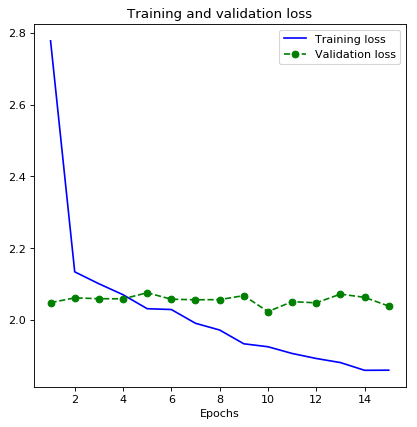

In [21]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

def perf_plot(history, what = 'loss'):
    x = history.history[what]
    val_x = history.history['val_' + what]
    epochs = np.asarray(history.epoch) + 1
    figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(epochs, x, linestyle='-', marker='', color='blue', label = "Training " + what)
    plt.plot(epochs, val_x, linestyle='--', marker='o', color='green', label = "Validation " + what)
    plt.title("Training and validation " + what)
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()
    return None

perf_plot(history)

# Plot predictions & ground truth

In [22]:
#grab the array of items to plot
629145480
sampleFullSize = float_data.shape[0] #629145480
indices = []
predictions = []
groundTruth = []
#for i in range(0,sampleFullSize,int(sampleFullSize/10)): #test on 10 samples for debug
#for i in range(609145480,sampleFullSize,150000):
#for i in range(0,sampleFullSize,150000): #Full sample
for i in range(0,thirdEq,150000): #validation set is up to the 3rd earthquake, so plot ground truth based on that
    """
    #take 150k acoustic data, reformat it, then predict
    seg = float_data[i:i+150000,0]
    x = seg
    x = create_X(x)
    x = np.expand_dims(x, 0)
    inp = [x, x]
    pred = model_st.predict(inp)

    grTr = float_data[i+150000-1][1]
    
    predictions.append(pred[0])
    groundTruth.append(grTr)
    indices.append(i+150000-1)
    """
    """
    samples_ret = np.empty((1,1))
    seg = float_data[i:i+150000,0]
    x = seg
    xNorm = create_X(x)
    xFFT = create_X(x,modelType="FFT")
#     x = np.expand_dims(x, 0)
#     inp = [x, x, x]
    
    for counter,model in enumerate(all_models) :
        with graph.as_default():
            #print(counter)
            if (counter==0 or counter==1):
                print(counter)
                x_batch = np.empty((1,150, 32))
                x_batch[0] = xNorm
                samples_ret = np.concatenate((samples_ret, model.predict_on_batch(x_batch)), axis=1)
            elif (counter==2): #FFT
                print(counter)
                x_batch = np.empty((1,150, 104))
                x_batch[0] = xFFT
                samples_ret = np.concatenate((samples_ret, model.predict_on_batch(x_batch)), axis=1)
        # batch_size x number of models/predictions
        
    samples_ret = samples_ret[:, 1:] # ignoring blank first column from initial concatenation with empty array
    #print(samples_ret.shape)
    pred = model_st.predict(samples_ret)
    grTr = float_data[i+150000-1][1]
    
    predictions.append(pred[0])
    groundTruth.append(grTr)
    indices.append(i+150000-1)
    """
    
    seg = float_data[i:i+150000,0]
    x = seg
    #print(x.shape)
    
    xNorm = create_X(x)
    xFFT = create_X(x,modelType="FFT")
    
    xNorm = np.expand_dims(xNorm, 0)
    xFFT = np.expand_dims(xFFT, 0)
    
    y =  np.zeros((1, len(all_models)))
    
    for counter,model in enumerate(all_models) :
        with graph.as_default():
            
            #print(counter)
            if (counter==0 or counter==1):
                y[:, counter] = (model.predict(xNorm))
            elif (counter==2): #FFT
                y[:, counter] = (model.predict(xFFT))
            elif (counter==3 or counter==4): #DeepRNN, convRNN
                y[:, counter] = (model.predict(xNorm))
    grTr = float_data[i+150000-1][1]
    
    #print("appending prediction: ",i,model_st.predict(y)[0])
    predictions.append(model_st.predict(y)[0])
    groundTruth.append(grTr)
    indices.append(i+150000-1)

In [23]:
#print(indices)
#print(predictions)
#print(groundTruth)

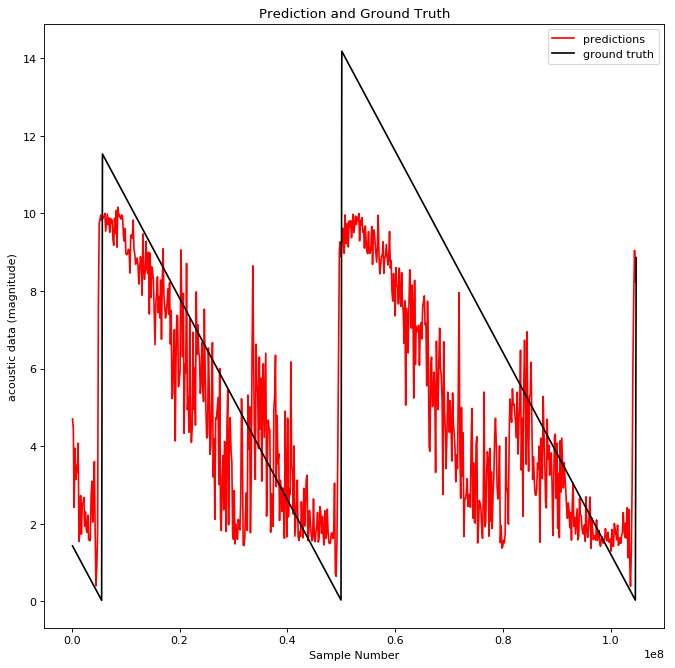

In [24]:
#plot the arrays
from matplotlib.pyplot import figure

def PredictionsGroundtruthPlot(indices,predictions,groundTruth):
    figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(indices, predictions, 'red', label = "predictions")
    plt.plot(indices, groundTruth, 'black', label = "ground truth")
    plt.title("Prediction and Ground Truth")
    plt.xlabel("Sample Number")
    plt.ylabel("acoustic data (magnitude)")
    plt.legend()
    plt.show()
    return None
PredictionsGroundtruthPlot(indices,predictions,groundTruth)


# Load submission file

In [25]:
# Load best model weights
from keras.models import load_model
print(os.listdir("../input/"))
print(os.listdir("../working/"))
# pred_model = load_model('meta_learner.hdf5')

submission = pd.read_csv(DATA_PATH + 'sample_submission.csv', index_col='seg_id', dtype={"time_to_failure": np.float32})
# Load each test data, create the feature matrix, get numeric prediction


for i, seg_id in enumerate(tqdm(submission.index)):
  #  print(i)
    seg = pd.read_csv(DATA_PATH + 'test/' + seg_id + '.csv')
    x = seg['acoustic_data'].values
    #print(x.shape)
    
    xNorm = create_X(x)
    xFFT = create_X(x,modelType="FFT")
    
    xNorm = np.expand_dims(xNorm, 0)
    xFFT = np.expand_dims(xFFT, 0)
    
#     inp = [x, x, x]
    
    y =  np.zeros((1, len(all_models)))
    
    for counter,model in enumerate(all_models) :
        with graph.as_default():
            
            #print(counter)
            if (counter==0 or counter==1):
                y[:, counter] = (model.predict(xNorm))
            elif (counter==2): #FFT
                y[:, counter] = (model.predict(xFFT))
            elif (counter==3 or counter==4): #DeepRNN
                y[:, counter] = (model.predict(xNorm))
                
    submission.time_to_failure[i] = model_st.predict(y)

submission.head()

# Save
submission.to_csv('submission.csv')

  0%|          | 2/2624 [00:00<02:42, 16.10it/s]

['LANL-Earthquake-Prediction', 'modelsforstacking']
['model.hdf5', '__notebook__.ipynb', 'model_graph.png', '__output__.json']


100%|██████████| 2624/2624 [02:29<00:00, 18.79it/s]


## References
1.  https://www.kaggle.com/gpreda/lanl-earthquake-eda-and-prediction
2.  https://www.kaggle.com/mayer79/rnn-starter-for-huge-time-series/
3.  https://machinelearningmastery.com/stacking-ensemble-for-deep-learning-neural-networks/
